<a href="https://colab.research.google.com/github/LuizVicenteJr/insiders_clustering/blob/main/insiders_clustering_cycle3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Planejamento da solução :

* Problema de negócio -> Selecionar os clientes mais valiosos para integrar um programa de fidelização

*Dataset -> Vendas de um e-commerce durante o período de um ano

#Perguntas da equipe de negócios :    
* Quantos clientes farão parte do grupo?
* Quais as principais características desses clientes?
* Qual a porcentagem de contribuição do faturamento vinda dos Insiders?
* Qual a expectativa de faturamente deste grupo para os próximos meses?
* Quais as condições para uma pessoa ser elegível ao Insiders?
*  Quais as condições para uma pessoa ser removida do Insiders?
* Qual a garantia que o programa Insiders é melhor que o restante da base?
* Quais ações o time de marketing pode realizar para aumentar o faturamento




# 0.0 IMPORTS

In [100]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [189]:
import pandas as pd
import numpy as np
import seaborn as sns
import umap.umap_ as umap 
import regex as re

from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML

from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp
from plotly import express as px
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


## 0.1 HELPER FUNCTIONS

In [102]:
def jupyter_settings():
  %matplotlib inline
  %pylab inline
  plt.style.use( 'bmh' )
  plt.rcParams['figure.figsize'] = [25, 12]
  plt.rcParams['font.size'] = 24
  display( HTML( '') )
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  pd.set_option( 'display.expand_frame_repr', False )
  sns.set()

## 0.2 LOAD DATASET

In [103]:
df_raw = pd.read_csv('/content/Ecommerce.csv',encoding='unicode_escape')

#drop extra column
df_raw= df_raw.drop(columns=['Unnamed: 8'],axis=1)

# 1.0 DATA DESCRIPTION

In [104]:
df1 = df_raw.copy()

## 1.1 RENAME COLUMNS

In [105]:
df_raw.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [106]:
cols_new =['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']

df1.columns = cols_new

## 1.2 DATA DIMENSIONS

In [107]:
print('Number of rows : {}'.format(df1.shape[0]))
print('Number of rows : {}'.format(df1.shape[1]))

Number of rows : 541909
Number of rows : 8


## 1.3 DATA TYPES

In [108]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 CHECK NA

In [109]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 REPLACE NA

In [110]:
df1 = df1.dropna(subset=['description','customer_id'])

print('Removed data: {:.2f}'.format(1-(df1.shape[0]/df_raw.shape[0])))


Removed data: 0.25


## 1.6 CHANGE DTYPES

In [111]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [112]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [113]:
#invoice date
df1['invoice_date']= pd.to_datetime(df1['invoice_date'],format= '%d-%b-%y')

#customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


## 1.7 DESCRIPTIVE STATISTICS

In [114]:
num_attributes= df1.select_dtypes(include=['int64','float64'])
cat_attributes= df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [115]:
#central tendency
ct1= pd.DataFrame(num_attributes.apply(np.mean)).T
ct2= pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion
d1= pd.DataFrame(num_attributes.apply(np.std)).T
d2= pd.DataFrame(num_attributes.apply(np.min)).T
d3= pd.DataFrame(num_attributes.apply(np.max)).T
d4= pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5= pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6= pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns=['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [116]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


### <font color='red'> 1.7.1.1 Investigating</font>
* "quantity" negativa(pode ser devolução)
* "preço unitário igual a zero(pode ser algum tipo de promoção)

### 1.7.2 Categorical Attributes

### invoice_no

In [117]:
df_letter_invoices= df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+',x))),:]
df_letter_invoices.head()

print('Total number of invoices: {}'.format( len(df_letter_invoices)))
print('Total number of negative quantity: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity']< 0])))

Total number of invoices: 8905
Total number of negative quantity: 8905


### stock code

In [118]:
#check stock code only characters
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$',x) ) ),'stock_code'].unique()

#Remove stock code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

### description

In [119]:
#ação: delete description

### country

In [120]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [121]:
df1['country'].value_counts(normalize=True)

United Kingdom          0.889509
Germany                 0.023339
France                  0.020871
EIRE                    0.018398
Spain                   0.006226
Netherlands             0.005828
Belgium                 0.005086
Switzerland             0.004614
Portugal                0.003638
Australia               0.003095
Norway                  0.002669
Italy                   0.001974
Channel Islands         0.001863
Finland                 0.001708
Cyprus                  0.001529
Sweden                  0.001136
Austria                 0.000986
Denmark                 0.000956
Japan                   0.000880
Poland                  0.000838
USA                     0.000715
Israel                  0.000615
Unspecified             0.000600
Singapore               0.000563
Iceland                 0.000447
Canada                  0.000371
Greece                  0.000359
Malta                   0.000312
United Arab Emirates    0.000167
European Community      0.000150
RSA       

In [122]:
df1[['customer_id','country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id',ascending=False)

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


# 2.0 DATA FILTER

In [123]:
df2 = df1.copy()

In [124]:
###====  Numerical Attributes====###
#unit_price
df2= df2.loc[df2['unit_price']> 0.04,:]

###====Categorical Attributes====###
#stock code
df2= df2[~df2['stock_code'].isin(['POST','D','M','DOT','CRUK','C2'])]

#description
df2= df2.drop(columns='description',axis=1)

#map
df2=df2[~df2['country'].isin(['European Community','Unspecified'])]

#quantity
df2_returns= df2.loc[df2['quantity']< 0, :]
df2_purchases= df2.loc[df2['quantity']> 0, :]

# 3.0 FEATURE ENGINEERING

In [158]:
df3 = df2.copy()

In [159]:
df_ref= df3.drop(['invoice_no','stock_code','quantity',
                  'invoice_date','unit_price','country'],axis=1).drop_duplicates(ignore_index=True)

In [160]:
#gross revenue 
df2_purchases.loc[:,'gross_revenue'] = df2_purchases.loc[:,'quantity'] * df2_purchases.loc[:,'unit_price']

#monetary
df_monetary= df2_purchases.loc[:,['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()

df_ref= pd.merge(df_ref,df_monetary,on='customer_id',how='left')


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [161]:
#recency
df_recency= df2_purchases.loc[:,['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days']= (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency= df_recency[['customer_id','recency_days']].copy()

df_ref= pd.merge(df_ref,df_recency,on='customer_id',how='left')


In [162]:
#frequency
df_freq= df2_purchases.loc[:,['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()

df_ref= pd.merge(df_ref,df_freq,on='customer_id',how='left')


In [163]:
#average ticket
df_avg_ticket= df2_purchases.loc[:,['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})

df_ref= pd.merge(df_ref,df_avg_ticket,on='customer_id',how='left')


In [164]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5391.21,372.0,34.0,18.152222
1,13047,3232.59,56.0,9.0,18.904035
2,12583,6705.38,2.0,15.0,28.902500
3,13748,948.25,95.0,5.0,33.866071
4,15100,876.00,333.0,3.0,292.000000


# 4.0 EDA


In [166]:
df4= df_ref.dropna().copy()

# 5.0 DATA PREPARATION

In [187]:
df5 = df4.copy()

In [190]:
## Standard Scaler
ss= pp.StandardScaler()

df5['gross_revenue']= ss.fit_transform(df5[['gross_revenue']])
df5['recency_days']= ss.fit_transform(df5[['recency_days']])
df5['invoice_no']= ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket']= ss.fit_transform(df5[['avg_ticket']])


In [191]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,0.378073,2.791512,3.893141,-0.033934
1,13047,0.135815,-0.361004,0.621632,-0.033422
2,12583,0.525560,-0.899726,1.406794,-0.026617
3,13748,-0.120552,0.028072,0.098191,-0.023239
4,15100,-0.128660,2.402435,-0.163530,0.152448


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


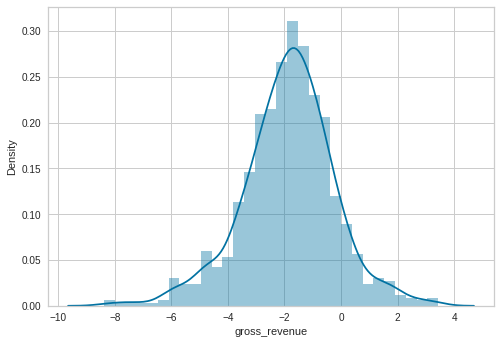

In [195]:
sns.distplot(np.log(df5['gross_revenue']))

# 6.0 FEATURE SELECTION

In [196]:
df6= df5.copy()

#7.0 Hyperparameter Fine-Tuning

In [197]:
X= df6.drop(columns=['customer_id'])

In [198]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,0.378073,2.791512,3.893141,-0.033934
1,0.135815,-0.361004,0.621632,-0.033422
2,0.525560,-0.899726,1.406794,-0.026617
3,-0.120552,0.028072,0.098191,-0.023239
4,-0.128660,2.402435,-0.163530,0.152448


In [199]:
clusters= [2,3,4,5,6,7]

In [38]:
#wss=[]
#for k in clusters:
  ##model definition
  #kmeans= c.KMeans(init='random',n_clusters=k,n_init=10,max_iter=300,random_state=42)

  ##model training
  #kmeans.fit(X)

  ##validation
  #wss.append(kmeans.inertia_)

##plot wss - elbow method
#plt.plot(clusters,wss,linestyle='--',marker= 'o',color= 'b')
#plt.xlabel('K');
#plt.ylabel('Within-Cluster Sum of Square'); 
#plt.title('WSS vs K');

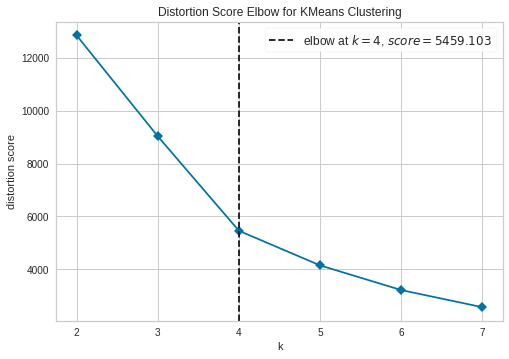

In [200]:
from yellowbrick.cluster import KElbowVisualizer

kmeans= KElbowVisualizer(c.KMeans(), k=clusters,timings=False)
kmeans.fit(X)
kmeans.show()

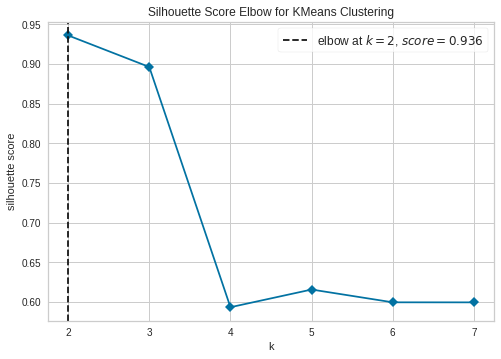

In [201]:
from yellowbrick.cluster import KElbowVisualizer
kmeans= KElbowVisualizer(c.KMeans(),k=clusters,metric='silhouette',timings=False)
kmeans.fit(X)
kmeans.show()

## 7.1 Silhouette Analysis

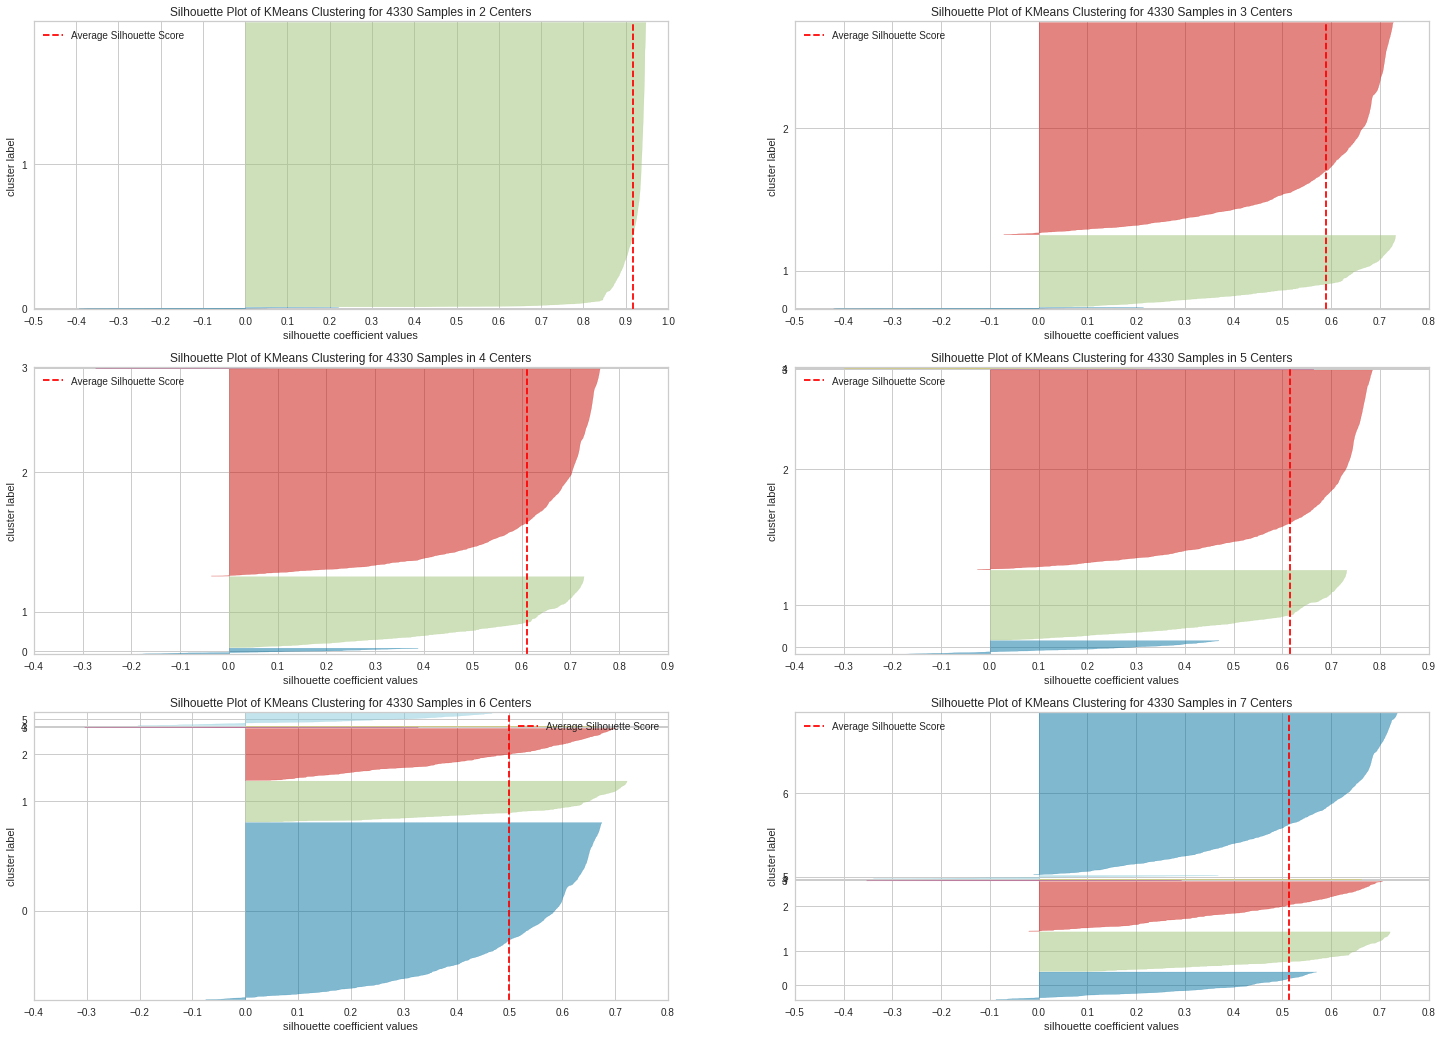

In [202]:
fig,ax= plt.subplots(3,2,figsize=(25,18))
for k in clusters: 
  km= c.KMeans(n_clusters= k, init='random',n_init=10, max_iter=100, random_state=42)
  q,mod= divmod(k,2)
  visualizer= SilhouetteVisualizer(km, colors='yellowbrick',ax= ax[q-1][mod])
  visualizer.fit(X)
  visualizer.finalize()

# 8.0 MODEL TRAINING

## 8.1 K-MEANS

In [203]:
#model definition
k=3
kmeans= c.KMeans(init='random', n_clusters= k, n_init= 10, max_iter= 300)
#model training
kmeans.fit(X)

#clustering
labels= kmeans.labels_

## 8.2 Cluster Validation

In [205]:
from sklearn import metrics as m

In [206]:
#WSS
print('WSS value: {}'.format(kmeans.inertia_))
 
#SS
print('SS value: {}'.format(m.silhouette_score(X,labels,metric='euclidean')))

WSS value: 9408.255050647289
SS value: 0.5893633811956627


# 9.0 Cluster Analysis

In [207]:
df9 = df6.copy()
df9['cluster']= labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,0.378073,2.791512,3.893141,-0.033934,1
1,13047,0.135815,-0.361004,0.621632,-0.033422,2
2,12583,0.525560,-0.899726,1.406794,-0.026617,2
3,13748,-0.120552,0.028072,0.098191,-0.023239,2
4,15100,-0.128660,2.402435,-0.163530,0.152448,1


## 9.1 Visualization Inspection

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


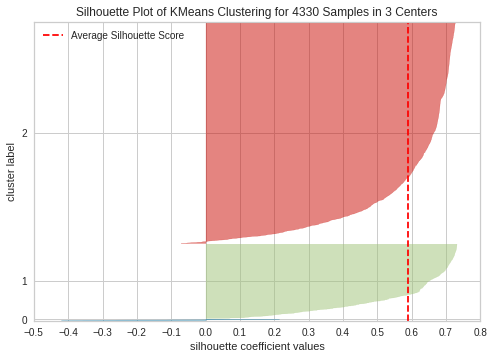

In [208]:
visualizer= SilhouetteVisualizer(kmeans,colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2dplot

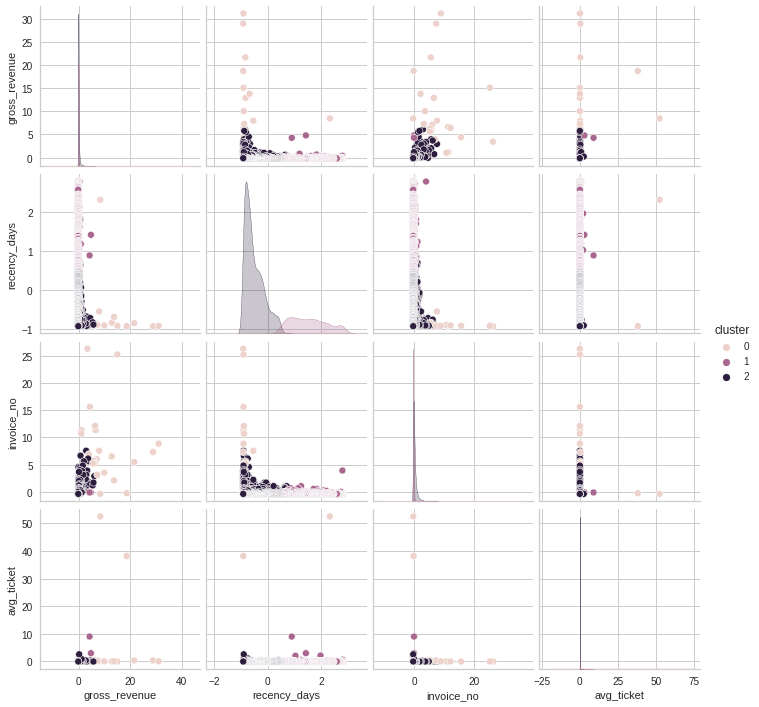

In [209]:
df_viz= df9.drop(columns='customer_id',axis=1)
sns.pairplot(df_viz,hue='cluster')

## 9.3 UMAP

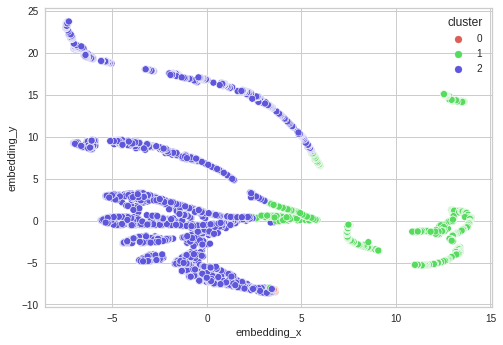

In [211]:
reducer= umap.UMAP(n_neighbors=35,random_state=42)
embedding= reducer.fit_transform(X)

#embedding
df_viz['embedding_x']= embedding[:,0]
df_viz['embedding_y']= embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',
                hue='cluster',
                palette=sns.color_palette('hls',n_colors=len(df_viz['cluster'].unique())),
                data= df_viz)